In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
Japan = pd.read_csv('Cleaned Data/Japan.csv')
China = pd.read_csv('Cleaned Data/China.csv')
Korea = pd.read_csv('Cleaned Data/Korea.csv')
Singapore = pd.read_csv('Cleaned Data/Singapore.CSV')
Malaysia = pd.read_csv('Cleaned Data/Malaysia.CSV')
Highincome  = pd.read_csv('Cleaned Data/Highincome_DF.CSV')
UpperMidincome = pd.read_csv('Cleaned Data/UpperMidincome_DF.CSV')
Japan.set_index('Year', inplace = True)
China.set_index('Year', inplace = True) 
Korea.set_index('Year', inplace = True)
Singapore.set_index('Year', inplace = True)
Malaysia.set_index('Year', inplace = True) 
Highincome.set_index('Year', inplace = True)
UpperMidincome.set_index('Year', inplace = True) 
Japan.dropna(inplace = True)
China.dropna(inplace = True)
Korea.dropna(inplace = True)
Singapore.dropna(inplace = True)
Singapore.dropna(inplace = True)
Malaysia.dropna(inplace = True)

In [3]:
China.index =  pd.to_datetime(China.index, format='%Y')
China.index = China.index.strftime("%Y")
Korea.index =  pd.to_datetime(Korea.index, format='%Y')
Korea.index = Korea.index.strftime("%Y")
Singapore.index =  pd.to_datetime(Singapore.index, format='%Y')
Singapore.index = Singapore.index.strftime("%Y")
Japan.index =  pd.to_datetime(Japan.index, format='%Y')
Japan.index = Japan.index.strftime("%Y")

In [4]:
def population_number(x):
    x1 = x[['14 Under', '15 to 64','64 Above','Female(%)']]
    x2 = x1*.01
    x['14 Population'] = x2['14 Under']*x['Total pop']
    x['15 to 64 Population'] = x2['15 to 64']*x['Total pop']
    x['64 Above Population'] = x2['64 Above']*x['Total pop']
    x['Female Population'] = x2['Female(%)']*x['Total pop']
    x['Male Population'] = x['Total pop'] - x['Female Population']
    return x
China = population_number(China)
China.dropna(inplace = True)
Japan = population_number(Japan)
Japan.dropna(inplace = True)
Korea = population_number(Korea)
Korea.dropna(inplace = True)

In [5]:
#Creating test and train to see how much the total population have effect on the GDP Growth  
features =['Gov Exp', 'Total pop', 'GNI per Capita']
def Test_Train(x):
    y = x['GDP'].pct_change().dropna()
    X = x[features].pct_change().dropna()
    y_train =  y[:45]
    y_test = y[45:]
    X_train =  X[:45]
    X_test =  X[45:]
    return (X_train, X_test, y_train, y_test)

In [6]:
from sklearn.preprocessing import MinMaxScaler
def OLS_Reg(x):
    X_train, X_test, y_train, y_test = Test_Train(x)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    result = sm.OLS(y_train, X_train).fit()
    return(result.summary())
print('China Summary:', OLS_Reg(China))

China Summary:                                  OLS Regression Results                                
Dep. Variable:                    GDP   R-squared (uncentered):                   0.328
Model:                            OLS   Adj. R-squared (uncentered):              0.279
Method:                 Least Squares   F-statistic:                              6.819
Date:                Thu, 21 Jul 2022   Prob (F-statistic):                    0.000757
Time:                        18:14:21   Log-Likelihood:                          33.480
No. Observations:                  45   AIC:                                     -60.96
Df Residuals:                      42   BIC:                                     -55.54
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

Based on this, x1, which is the fertility rate, seems to have bigger signficance for China. Moreover, having more number of younger population seem to have positive coefficent than aging population.

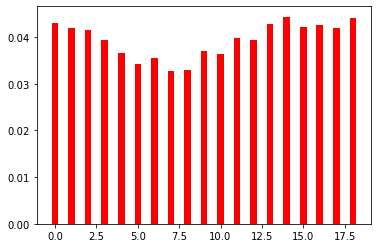

In [7]:
#Using KNN regressor and see which depth works the best
from sklearn.neighbors import KNeighborsRegressor
score = []
def KNNR(i, x):
        X_train, X_test, y_train, y_test = Test_Train(x)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scale = scaler.transform(X_train)
        X_test_scale = scaler.transform(X_test)
        knn = KNeighborsRegressor(i)
        knn.fit(X_train_scale, y_train)
        prediction = knn.predict(X_test_scale)
        return(mae(prediction, y_test))
for i in range(1,20):
    score.append(KNNR(i, China))
for i in range(len(score)):
    plt.bar(i, score[i], width = .4, color = 'red')

mae: 0.03433785721777027
r2_score: 0.3452721523434369
mse: 0.3452721523434369


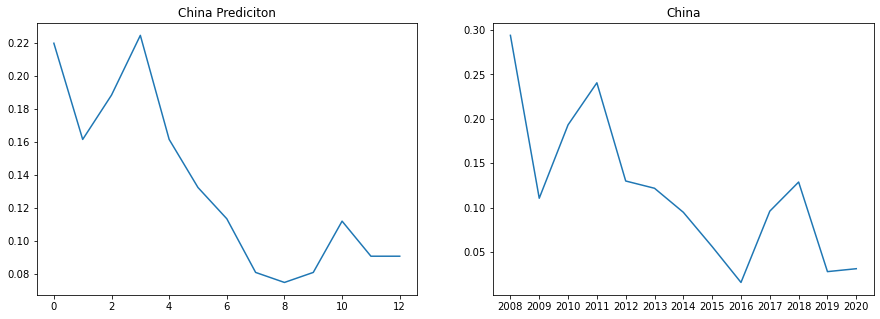

In [8]:
def KNNR(x):
        X_train, X_test, y_train, y_test = Test_Train(x)
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train_scale = scaler.transform(X_train)
        X_test_scale = scaler.transform(X_test)
        knn = KNeighborsRegressor(6)
        knn.fit(X_train_scale, y_train)
        prediction = knn.predict(X_test_scale)
        return(prediction, y_test, mae(prediction, y_test), r2_score(prediction, y_test), mse(prediction, y_test))
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(KNNR(China)[0])
ax[1].plot(KNNR(China)[1])
ax[0].set_title('China Prediciton')
ax[1].set_title('China')
print('mae:',KNNR(China)[2])
print ('r2_score:',KNNR(China)[3])
print( 'mse:',KNNR(China)[3]) 

mae: 0.025491473961078717
r2_score: 0.8570452695660797
mse: 0.8570452695660797


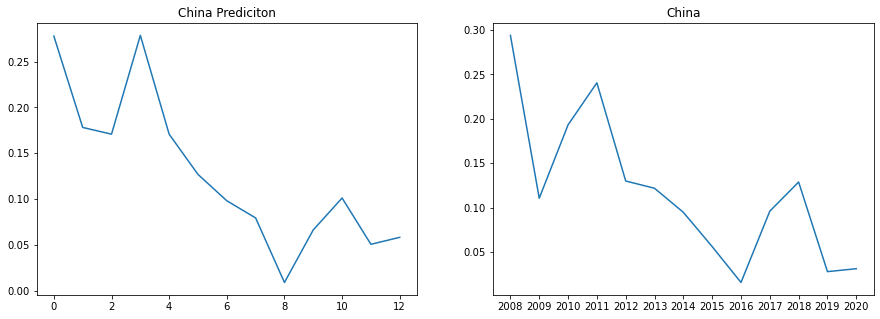

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
def Gradient(x):
    X_train, X_test, y_train, y_test = Test_Train(x)
    reg =GradientBoostingRegressor(random_state = 42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scale = scaler.transform(X_train)
    X_test_scale = scaler.transform(X_test)
    reg.fit(X_train_scale, y_train)
    prediction = reg.predict(X_test_scale)
    return(prediction, y_test, mae(prediction, y_test), r2_score(prediction, y_test), mse(prediction, y_test))
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(Gradient(China)[0])
ax[1].plot(Gradient(China)[1])
ax[0].set_title('China Prediciton')
ax[1].set_title('China')
print('mae:',Gradient(China)[2])
print ('r2_score:',Gradient(China)[3])
print( 'mse:',Gradient(China)[3]) 


mae: 0.03691902479960141


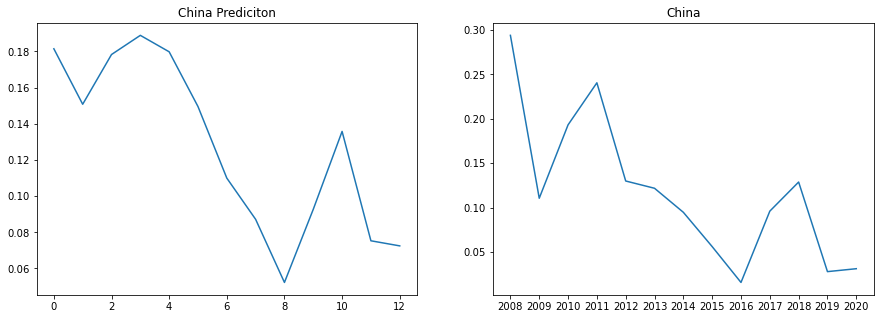

In [10]:
from sklearn.svm import SVR
def Support(x):
    X_train, X_test, y_train, y_test = Test_Train(x)
    reg =SVR()
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scale = scaler.transform(X_train)
    X_test_scale = scaler.transform(X_test)
    reg.fit(X_train_scale, y_train)
    prediction = reg.predict(X_test_scale)
    return(prediction, y_test, mae(prediction, y_test))
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(Support(China)[0])
ax[1].plot(Support(China)[1])
ax[0].set_title('China Prediciton')
ax[1].set_title('China')
print('mae:',Support(China)[2])


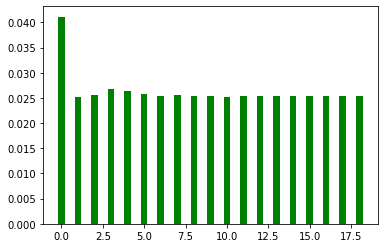

In [11]:
from sklearn.ensemble import RandomForestRegressor
score = []
def RandomForest(i,x):
    (X_train, X_test, y_train, y_test) = Test_Train(x)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scale = scaler.transform(X_train)
    X_test_scale = scaler.transform(X_test)
    regr = RandomForestRegressor(max_depth =i, random_state =42)
    regr.fit(X_train_scale, y_train)
    prediction = regr.predict(X_test_scale)
    return( mae(prediction, y_test))
for i in range(1,20):
    score.append(RandomForest(i,China))
for i in range(len(score)):
    plt.bar(i, score[i], width = .4, color = 'green')

mae: 0.02561989225221066
r2_score: 0.8515129901758665
mse: 0.8515129901758665


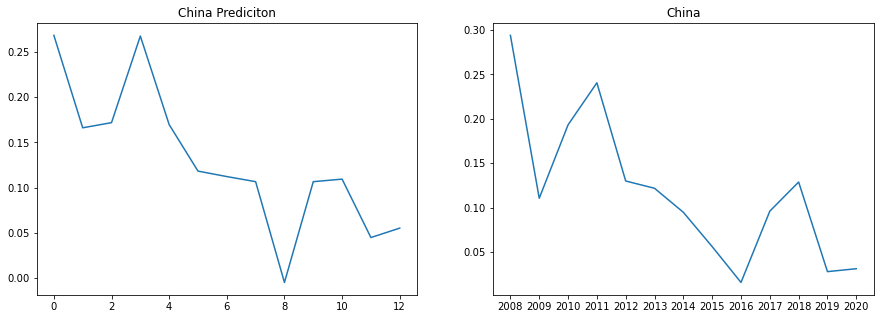

In [12]:
def RandomForest(x):
    (X_train, X_test, y_train, y_test) = Test_Train(x)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scale = scaler.transform(X_train)
    X_test_scale = scaler.transform(X_test)
    regr = RandomForestRegressor(max_depth = 3, random_state=42)
    regr.fit(X_train_scale, y_train)
    prediction = regr.predict(X_test_scale)
    return(prediction, y_test, mae(prediction, y_test), r2_score(prediction, y_test), mse(prediction, y_test))
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(RandomForest(China)[0])
ax[0].set_title('China Prediciton')
ax[1].plot(RandomForest(China)[1])
ax[1].set_title('China')
print('mae:',RandomForest(China)[2])
print ('r2_score:',RandomForest(China)[3])
print( 'mse:',RandomForest(China)[3]) 


[ 0.6552237  -0.          0.13540595]


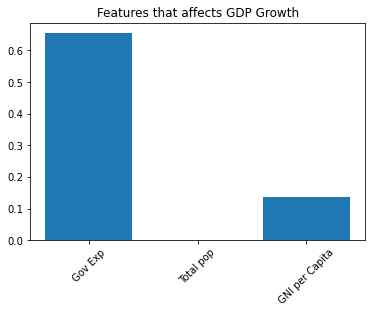

In [13]:
from sklearn.linear_model import Lasso
X = China[features].pct_change().dropna()
y= China["GDP"].pct_change().dropna()
lasso = Lasso(alpha =.001)
lasso_coef  = lasso.fit(X, y).coef_
print(lasso_coef)
plt.bar(X.columns, lasso_coef)
plt.xticks(rotation=45)
plt.title('Features that affects GDP Growth')
plt.show()

summary:                                SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   45
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  31.078
Date:                Thu, 21 Jul 2022   AIC                            -60.156
Time:                        18:14:25   BIC                            -58.371
Sample:                    01-01-1963   HQIC                           -59.494
                         - 01-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0143      0.003      5.449      0.000       0.009       0.019
Ljung-Box (L1) (Q):                   9.25   Jarque-Bera (JB):                 1.11
Prob(Q):                              

C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


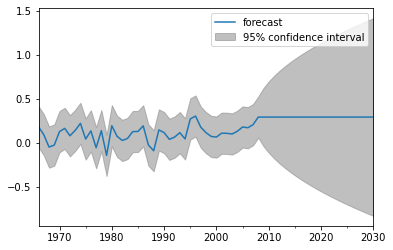

In [14]:
#Forecasting China's gdp growth
fig, ax = plt.subplots()
X_train, X_test, y_train, y_test = Test_Train(China)
mod = ARIMA(y_train, order=(0,1,0))
res = mod.fit()
print("summary:",res.summary())
fig = plot_predict(res, start='1966', end='2030', ax = ax)
plt.show()


C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be remove

summary:                              ARIMA Model Results                              
Dep. Variable:       D.GNI per Capita   No. Observations:                   58
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -406.073
Method:                           css   S.D. of innovations            265.687
Date:                Thu, 21 Jul 2022   AIC                            816.146
Time:                        18:14:26   BIC                            820.267
Sample:                    12-31-1963   HQIC                           817.751
                         - 12-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        180.3448     34.886      5.169      0.000     111.969     248.721


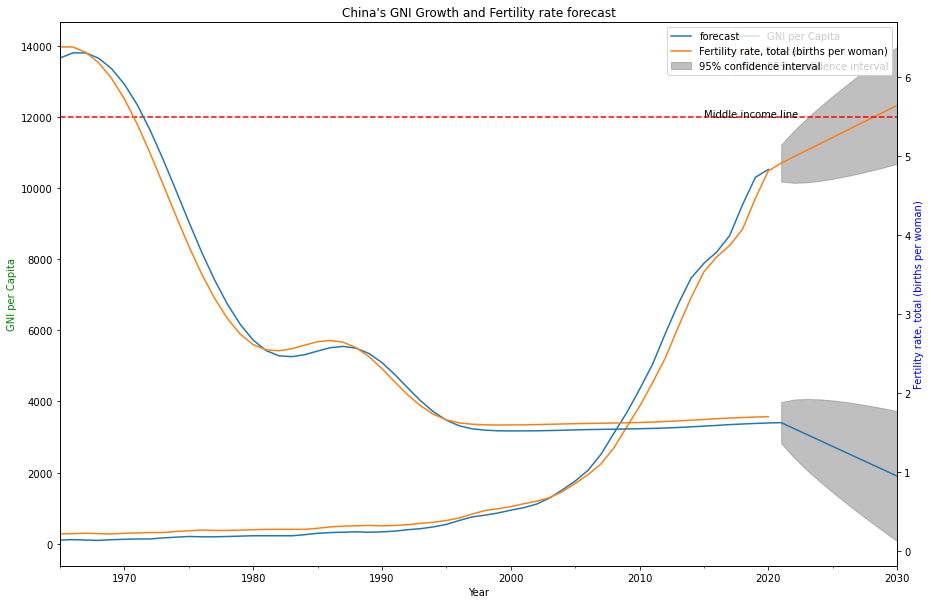

In [15]:
#Looking at China's Fertility rate and its GNI 
fig, ax = plt.subplots(figsize = (15,10))
#GNI
dta = China['GNI per Capita']
dta.index = pd.date_range(start='1962', end='2021', freq='A')
res = sm.tsa.ARIMA(dta, (0,1,0)).fit()
ax = dta.loc['1962': ].plot(ax=ax)
fig = res.plot_predict('1965', '2030', ax=ax,plot_insample=False)
plt.axhline(y=12000, color='r', linestyle='--')
ax.set_xlabel("Year")
ax.set_ylabel("GNI per Capita", color = 'green')
ax.set_title("China's GNI Growth and Fertility rate forecast")
ax.annotate('Middle income line', xy = ('2015', 12000))
print("summary:",res.summary())
ax2 = ax.twinx()
#Fertility 
dta2 = China['Fertility rate, total (births per woman)']
dta2.index = pd.date_range(start='1962', end='2021', freq='A')
res2 = sm.tsa.ARIMA(dta2, order=(0,1,0)).fit()
fig = res2.plot_predict(start='1965', end='2030', ax=ax2)
ax2.set_ylabel('Fertility rate, total (births per woman)', color = 'blue')
plt.show()

C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be remove

summary:                              ARIMA Model Results                              
Dep. Variable:       D.GNI per Capita   No. Observations:                   58
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -480.352
Method:                           css   S.D. of innovations            956.221
Date:                Thu, 21 Jul 2022   AIC                            964.704
Time:                        18:14:26   BIC                            968.825
Sample:                    12-31-1963   HQIC                           966.309
                         - 12-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        565.6897    125.558      4.505      0.000     319.601     811.779


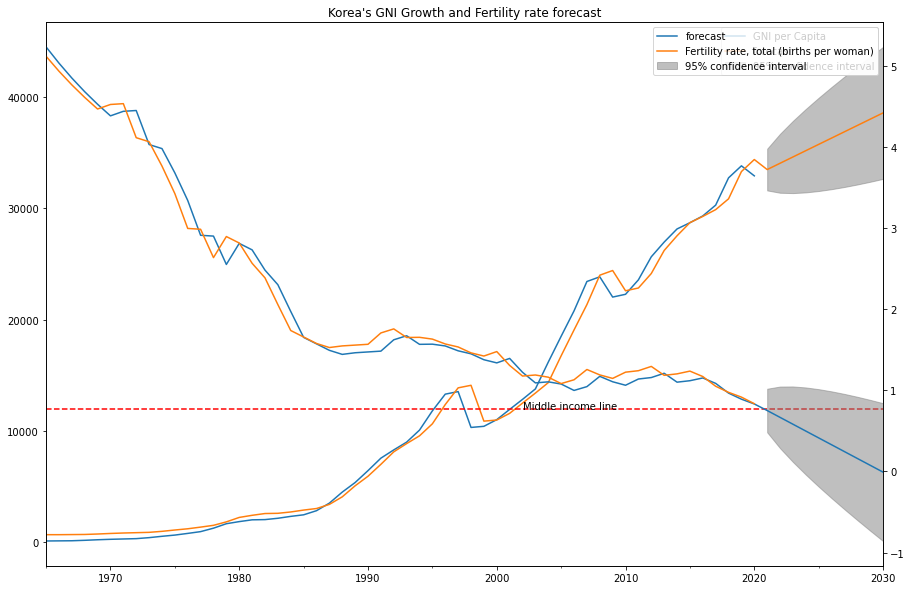

In [16]:
#Looking at Korea's Fertility rate and its GNI 
fig, ax = plt.subplots(figsize = (15,10))
#GNI
dta = Korea['GNI per Capita']
dta.index = pd.date_range(start='1962', end='2021', freq='A')
res = sm.tsa.ARIMA(dta, (0,1,0)).fit()
ax = dta.loc['1962': ].plot(ax=ax)
fig = res.plot_predict('1965', '2030', ax=ax,plot_insample=False)
plt.axhline(y=12000, color='r', linestyle='--')
ax.set_title("Korea's GNI Growth and Fertility rate forecast")
ax.annotate("Middle income line", xy=('2002', 12000))
print("summary:",res.summary())
ax2 = ax.twinx()
#Fertility 
dta2 = Korea['Fertility rate, total (births per woman)']
dta2.index = pd.date_range(start='1962', end='2021', freq='A')
res2 = sm.tsa.ARIMA(dta2, order=(0,1,0)).fit()
fig = res2.plot_predict(start='1965', end='2030', ax=ax2)
plt.show()

C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be remove

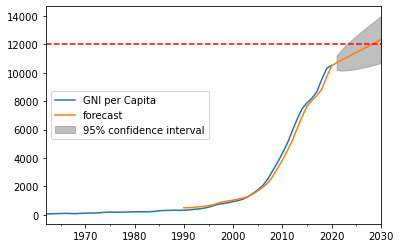

In [17]:
dta = China['GNI per Capita']
dta.index = pd.date_range(start='1962', end='2021', freq='A')
res = sm.tsa.ARIMA(dta, (0,1,0)).fit()
fig, ax = plt.subplots()
ax = dta.loc['1962': ].plot(ax=ax)
fig = res.plot_predict('1990', '2030', ax=ax,plot_insample=False)
plt.axhline(y=12000, color='r', linestyle='--')

In [18]:
features =['Birth rate', 'Life expectancy at birth',  'Fertility rate, total (births per woman)']
def Test_Train2(x):
    y = x['Pop Growth']
    X = x[features]
    y_train =  y[:45]
    y_test = y[45:]
    X_train =  X[:45]
    X_test =  X[45:]
    return (X_train, X_test, y_train, y_test)
China.columns

Index(['GNI per Capita', '14 Under', '15 to 64', '64 Above', 'Female(%)',
       'Total pop', 'Life expectancy at birth',
       'Fertility rate, total (births per woman)', 'Pop Growth',
       'Work Population(%)', 'Death rate', 'Birth rate', 'Trade balance',
       'Gov Exp', 'GDP', '14 Population', '15 to 64 Population',
       '64 Above Population', 'Female Population', 'Male Population'],
      dtype='object')

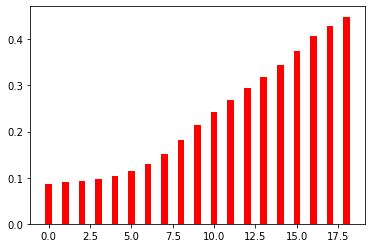

In [19]:
from sklearn.neighbors import KNeighborsRegressor
score = []
def KNNR(i, x):
        X_train, X_test, y_train, y_test = Test_Train2(x)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scale = scaler.transform(X_train)
        X_test_scale = scaler.transform(X_test)
        knn = KNeighborsRegressor(i)
        knn.fit(X_train_scale, y_train)
        prediction = knn.predict(X_test_scale)
        return(mae(prediction, y_test))
for i in range(1,20):
    score.append(KNNR(i, China))
for i in range(len(score)):
    plt.bar(i, score[i], width = .4, color = 'red')

mae: 0.08996303564285715
r2_score: 0.0
mse: 0.0


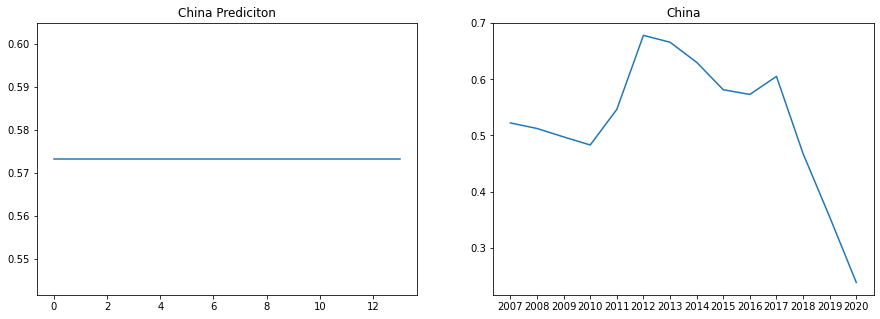

In [20]:
def KNNR(x):
        X_train, X_test, y_train, y_test = Test_Train2(x)
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train_scale = scaler.transform(X_train)
        X_test_scale = scaler.transform(X_test)
        knn = KNeighborsRegressor(2)
        knn.fit(X_train_scale, y_train)
        prediction = knn.predict(X_test_scale)
        return(prediction, y_test, mae(prediction, y_test), r2_score(prediction, y_test), mse(prediction, y_test))
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(KNNR(China)[0])
ax[1].plot(KNNR(China)[1])
ax[0].set_title('China Prediciton')
ax[1].set_title('China')
print('mae:',KNNR(China)[2])
print ('r2_score:',KNNR(China)[3])
print( 'mse:',KNNR(China)[3]) 

mae: 0.11041203222665608
r2_score: -6.897202938518114
mse: -6.897202938518114


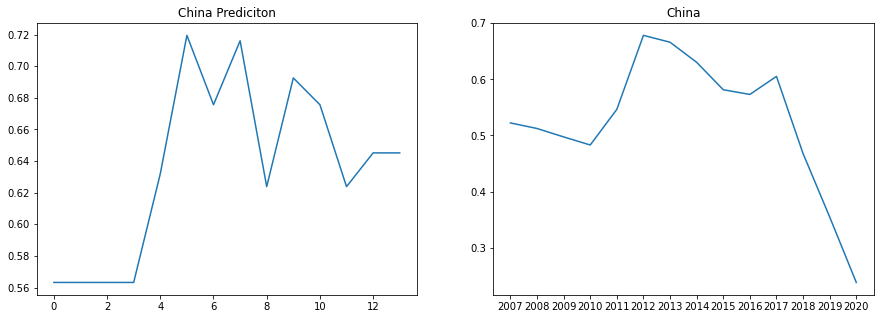

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
def Gradient(x):
    X_train, X_test, y_train, y_test = Test_Train2(x)
    reg =GradientBoostingRegressor(random_state = 42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scale = scaler.transform(X_train)
    X_test_scale = scaler.transform(X_test)
    reg.fit(X_train_scale, y_train)
    prediction = reg.predict(X_test_scale)
    return(prediction, y_test, mae(prediction, y_test), r2_score(prediction, y_test), mse(prediction, y_test))
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(Gradient(China)[0])
ax[1].plot(Gradient(China)[1])
ax[0].set_title('China Prediciton')
ax[1].set_title('China')
print('mae:',Gradient(China)[2])
print ('r2_score:',Gradient(China)[3])
print( 'mse:',Gradient(China)[3]) 

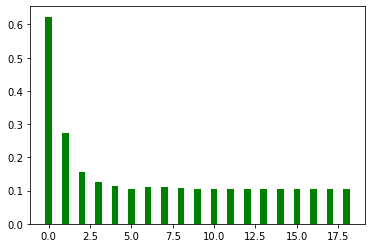

In [22]:
from sklearn.ensemble import RandomForestRegressor
score = []
def RandomForest(i,x):
    (X_train, X_test, y_train, y_test) = Test_Train2(x)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scale = scaler.transform(X_train)
    X_test_scale = scaler.transform(X_test)
    regr = RandomForestRegressor(max_depth =i, random_state =42)
    regr.fit(X_train_scale, y_train)
    prediction = regr.predict(X_test_scale)
    return( mae(prediction, y_test))
for i in range(1,20):
    score.append(RandomForest(i,China))
for i in range(len(score)):
    plt.bar(i, score[i], width = .4, color = 'green')

mae: 0.11322341694113071
r2_score: -7.483804266682247
mse: -7.483804266682247


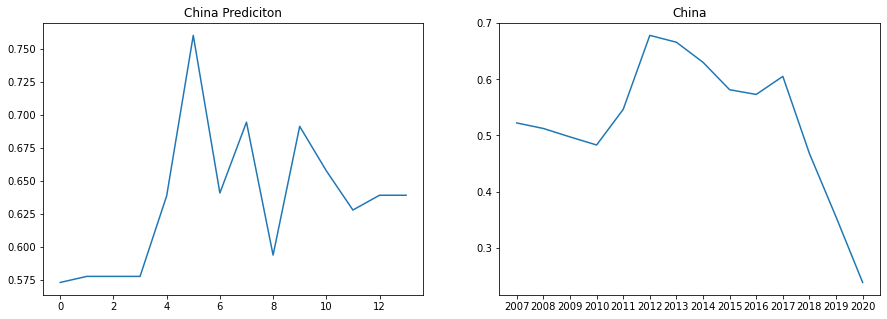

In [23]:
def RandomForest(x):
    (X_train, X_test, y_train, y_test) = Test_Train2(x)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scale = scaler.transform(X_train)
    X_test_scale = scaler.transform(X_test)
    regr = RandomForestRegressor(max_depth = 5, random_state=42)
    regr.fit(X_train_scale, y_train)
    prediction = regr.predict(X_test_scale)
    return(prediction, y_test, mae(prediction, y_test), r2_score(prediction, y_test), mse(prediction, y_test))
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(RandomForest(China)[0])
ax[0].set_title('China Prediciton')
ax[1].plot(RandomForest(China)[1])
ax[1].set_title('China')
print('mae:',RandomForest(China)[2])
print ('r2_score:',RandomForest(China)[3])
print( 'mse:',RandomForest(China)[3]) 


[0.10788345 0.0710093  0.17809683]


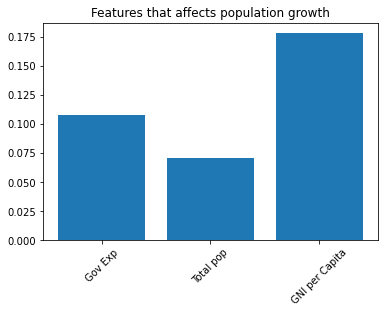

In [24]:
from sklearn.linear_model import Lasso
features =['Birth rate', 'Life expectancy at birth',  'Fertility rate, total (births per woman)']
X = China[features]
y = China['Pop Growth']
lasso = Lasso(alpha = .01)
lasso_coef  = lasso.fit(X, y).coef_
print(lasso_coef)
plt.bar(X_train.columns, lasso_coef)
plt.xticks(rotation=45)
plt.title('Features that affects population growth')
plt.show()